In [55]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import core.config as config
from core.model_loader import load_pretrained_VAE
from core.data_loader import TRAIN_loader, TEST_loader
from core.custom_loss import VAE_loss
from core.parameter_selection import ParameterSelection, CalculateScore
from core.visualize import plot_hist, AUROC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# CIFAR10

In [56]:
train_dist = 'cifar10'
opt = config.VAE_cifar10
netE, netG = load_pretrained_VAE(option=train_dist)

# Parameter Selection

In [66]:
Fisher, idx = ParameterSelection(netE=netE, 
                                 netG=netG, 
                                 dataloader=TRAIN_loader(option='cifar10'), 
                                 opt=opt, 
                                 thrsld1=1, 
                                 thrsld2=2)

Files already downloaded and verified


Fisher matrix:   2%|█▏                                                        | 1001/50000 [01:53<1:32:29,  8.83step/s]


In [67]:
for key, val in Fisher.items():
    print(val.shape)

torch.Size([99651])
torch.Size([16])
torch.Size([0])
torch.Size([0])
torch.Size([75])
torch.Size([1])
torch.Size([1])
torch.Size([68381])
torch.Size([11])
torch.Size([8])
torch.Size([108673])
torch.Size([5])
torch.Size([8])
torch.Size([213466])
torch.Size([58])
torch.Size([37])
torch.Size([168185])
torch.Size([83974])
torch.Size([8])
torch.Size([4])
torch.Size([215397])


In [68]:
cifar_Gradients = CalculateScore(netE,
                       netG,
                       TEST_loader(train_dist='cifar10', target_dist='cifar10'),
                       idx,
                       Fisher,
                       maxiter=1000,
                       opt=opt,)
svhn_Gradients = CalculateScore(netE,
                       netG,
                       TEST_loader(train_dist='cifar10', target_dist='svhn'),
                       idx,
                       Fisher,
                       maxiter=1000,
                       opt=opt,)

Files already downloaded and verified


Fisher Score:  10%|██████                                                       | 1001/10000 [00:51<07:46, 19.30step/s]


Using downloaded and verified file: ../data\test_32x32.mat


Fisher Score:   4%|██▎                                                          | 1001/26032 [00:52<22:01, 18.95step/s]


conv1.weight


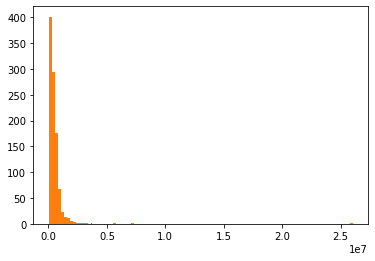

AUC for Gradient Norm is: 0.8233687315986788


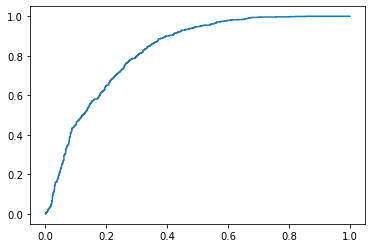

conv1.bias


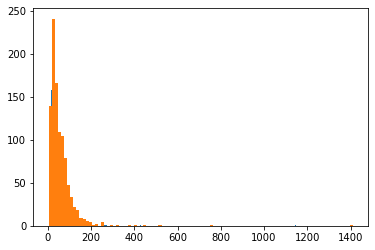

AUC for Gradient Norm is: 0.6989055820494738


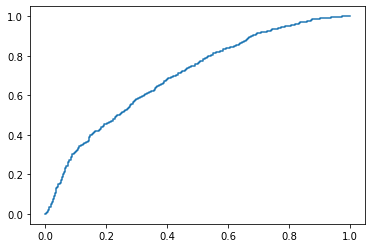

main.input-conv.weight


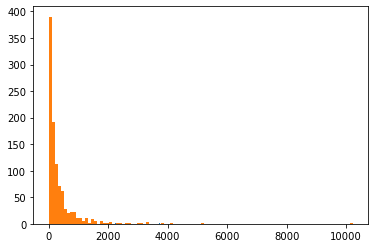

AUC for Gradient Norm is: 0.7039404225481173


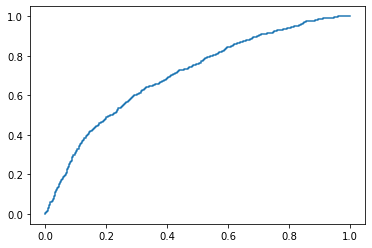

main.input-BN.weight


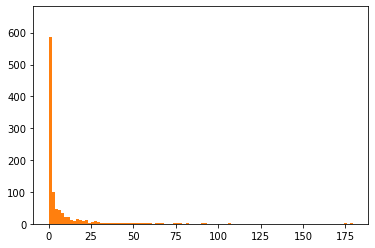

AUC for Gradient Norm is: 0.6974055880255458


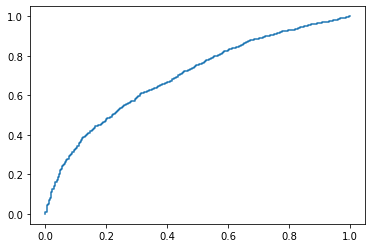

main.input-BN.bias


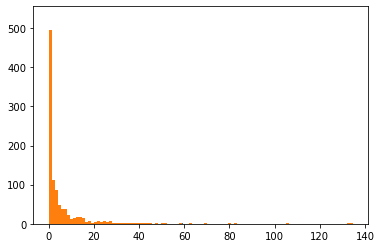

AUC for Gradient Norm is: 0.6938119768447137


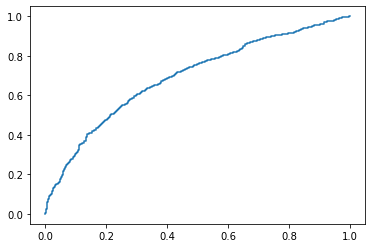

main.pyramid:64-128:conv.weight


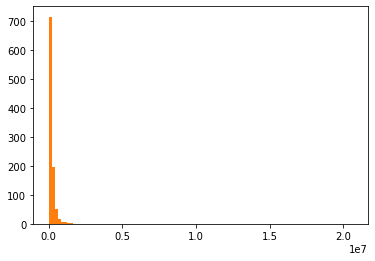

AUC for Gradient Norm is: 0.7364383010426252


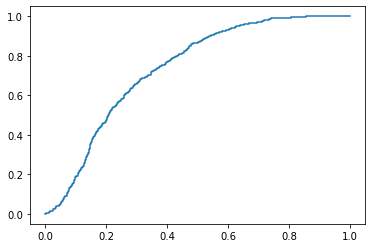

main.pyramid:128:batchnorm.weight


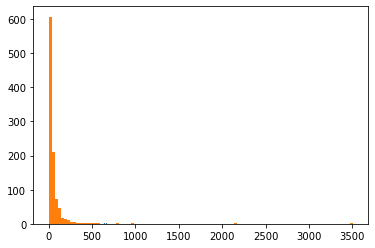

AUC for Gradient Norm is: 0.7443187477340728


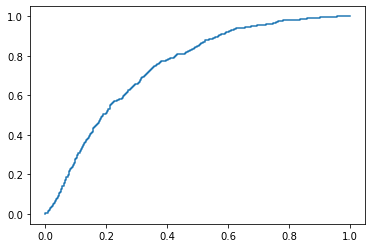

main.pyramid:128:batchnorm.bias


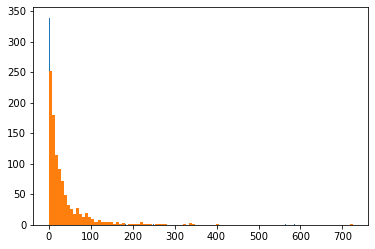

AUC for Gradient Norm is: 0.754193210385616


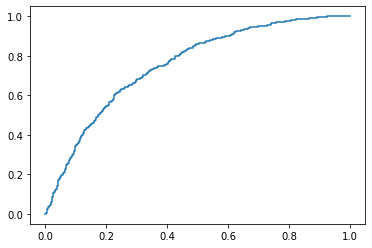

main.pyramid:128-256:conv.weight


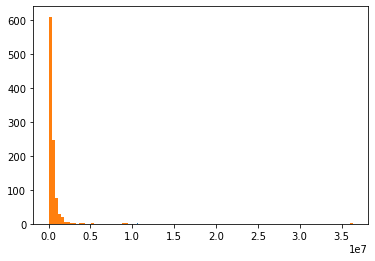

AUC for Gradient Norm is: 0.7931402663734406


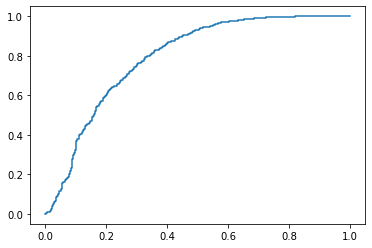

main.pyramid:256:batchnorm.weight


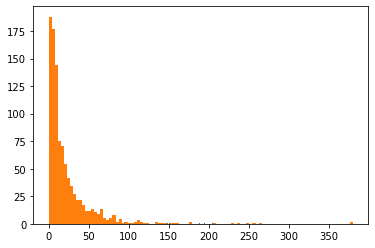

AUC for Gradient Norm is: 0.7086953836837302


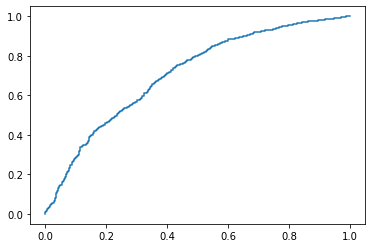

main.pyramid:256:batchnorm.bias


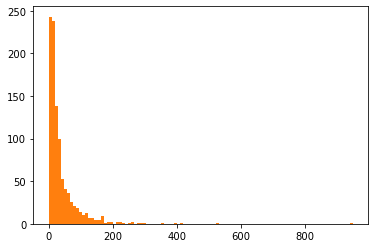

AUC for Gradient Norm is: 0.7556185035119383


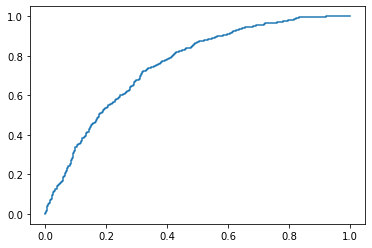

main.initial:100-256:convt.weight


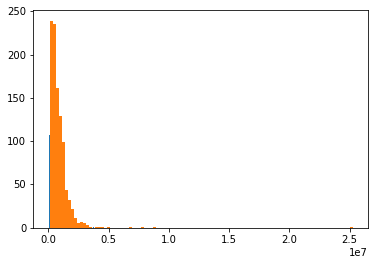

AUC for Gradient Norm is: 0.7771632383934726


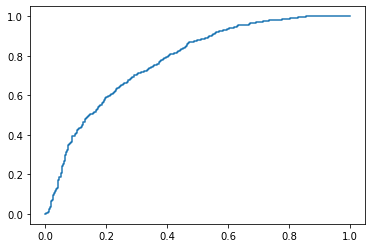

main.initial:256:batchnorm.weight


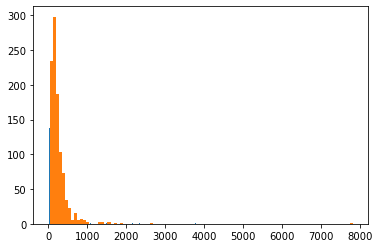

AUC for Gradient Norm is: 0.8103493611579238


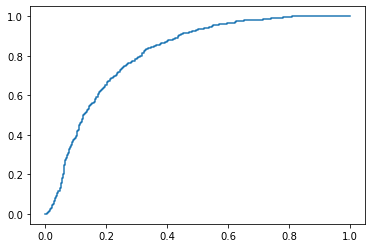

main.initial:256:batchnorm.bias


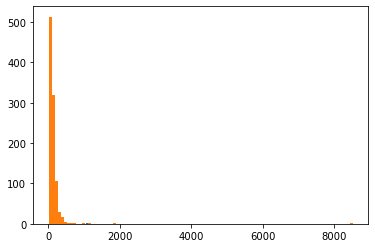

AUC for Gradient Norm is: 0.7462569870239562


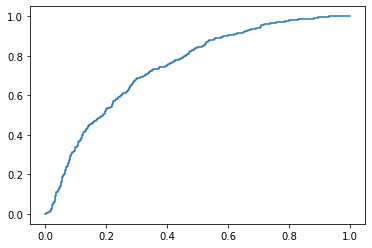

main.pyramid:256-128:convt.weight


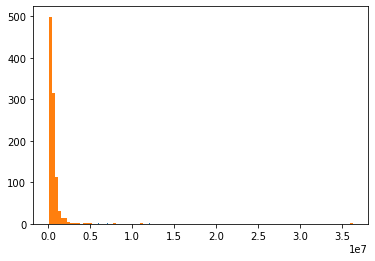

AUC for Gradient Norm is: 0.8189060999756973


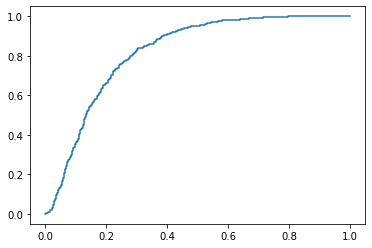

main.pyramid:128-64:convt.weight


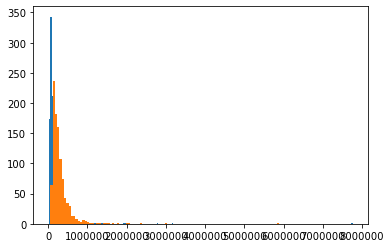

AUC for Gradient Norm is: 0.8585433922574013


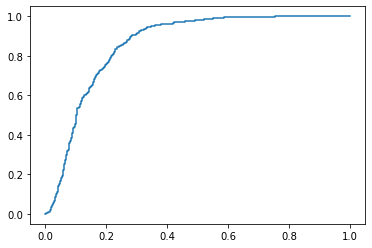

main.pyramid:64:batchnorm.weight


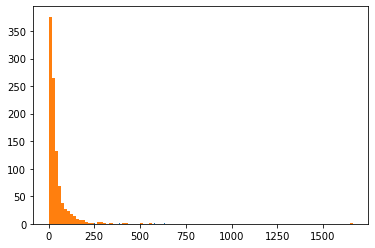

AUC for Gradient Norm is: 0.8020276811646169


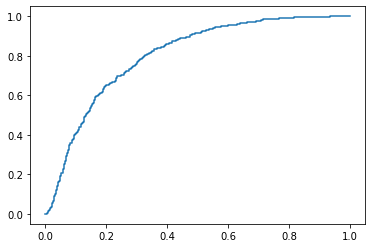

main.pyramid:64:batchnorm.bias


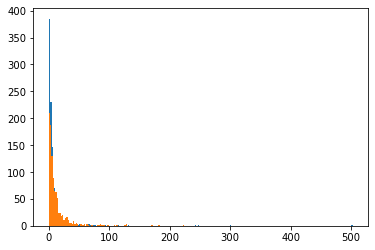

AUC for Gradient Norm is: 0.6220831789514782


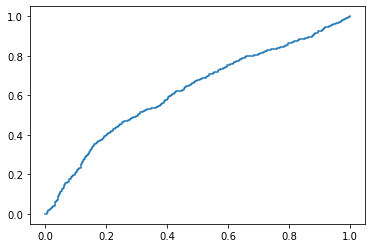

main.final:64-3:convt.weight


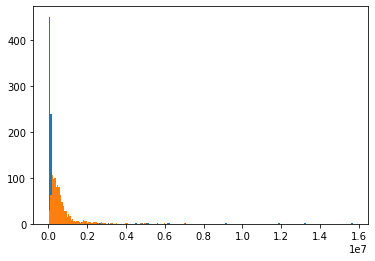

AUC for Gradient Norm is: 0.8540135298265744


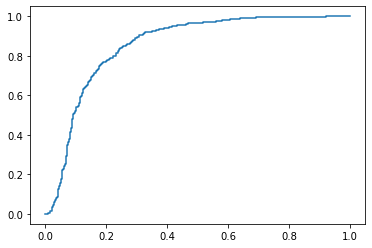

In [69]:
from sklearn import metrics
def AUROC(indist_Grads, outdist_Grads):    
    combined = np.concatenate((indist_Grads, outdist_Grads))
    label_1 = np.ones(len(indist_Grads))
    label_2 = np.zeros(len(outdist_Grads))
    label = np.concatenate((label_1, label_2))
    fpr, tpr, thresholds = metrics.roc_curve(label, combined, pos_label=0)
    #plot_roc_curve(fpr, tpr)
    rocauc = metrics.auc(fpr, tpr)
    print('AUC for Gradient Norm is: {}'.format(rocauc))
    plt.plot(fpr, tpr)
    plt.show()

import matplotlib.pyplot as plt
for key in idx:
    print(key)
    plt.hist(cifar_Gradients[key], bins=200)
    plt.hist(svhn_Gradients[key], bins=100)
    plt.show()
    AUROC(cifar_Gradients[key], svhn_Gradients[key])